<a href="https://colab.research.google.com/github/lauraciurca/Contradiction-Project/blob/main/MODEL_IMPLEMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preparation**

Libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline,metrics
from sklearn.metrics import f1_score,precision_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import tree
import pydotplus
import matplotlib.image as pltimg
from IPython.display import Image 
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
import pydot
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import models
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install stc
import pandas as pd
from stc import SparseTensorClassifier
from keras.layers.embeddings import Embedding
import keras
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot
from sklearn.tree import export_graphviz
import pydot
from nltk import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#connect to drive to access data
drive.mount('/content/drive')

Mounted at /content/drive


Data Import

In [2]:
data_train=pd.read_csv('/content/drive/MyDrive/Information Retrieval/data_train (1).csv')  #premise,hypothesis
data_test=pd.read_csv('/content/drive/MyDrive/Information Retrieval/data_test (1).csv')    #premise,hypothesis
train=pd.read_csv('/content/drive/MyDrive/Information Retrieval/train (2).csv') 
test=pd.read_csv('/content/drive/MyDrive/Information Retrieval/test (2).csv')   

In [3]:
train = train.iloc[: , 1:]
test = test.iloc[: , 1:]

In [4]:
train=train[["antonym_negation","sentence_sim","cosine_similarity","jaccard","subject_sim","polarity","polarity_difference","label"]]
test=test[["antonym_negation","sentence_sim","cosine_similarity","jaccard","subject_sim","polarity","polarity_difference"]]

In [5]:
training_set = train.dropna()
test_set= test.dropna()

In [6]:
training_set['label'] = training_set['label'].replace([0, 1],0)

In [7]:
data_train = data_train.iloc[: , 1:]
data_test = data_test.iloc[: , 1:]

In [8]:
data_train['label'] = data_train['label'].replace([0, 1],0)

Data Standardization and Data Split into Training and Testing Set

In [10]:
#Standardization
def standardized_dataset(dataset):
     m = dataset.apply(lambda x: ((x-np.mean(x))/np.std(x)))
     return m

In [11]:
#Normalization
def normalize_dataset(dataset):
    f = dataset.apply(lambda x: (x-min(x))/(max(x)-min(x)))
    return f

In [46]:
test_set= standardized_dataset(test_set)

In [47]:
y=training_set["label"]
training_set.drop(['label'],axis=1,inplace=True)

In [48]:
x = training_set
x=standardized_dataset(x)
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.2,random_state=4)

Word2Vec

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
!pip install pyemd
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-10-25 20:17:56--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  33.9MB/s    in 47s     

2021-10-25 20:18:44 (33.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [11]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
train_w2v=data_train.copy()

In [13]:
train_w2v["period"] = train_w2v["premise"] + train_w2v["hypothesis"]

In [15]:
#train_w2v['label'] = train_w2v['label'].replace(2,1) for NN

In [17]:
sentences = train_w2v['period']
sentence = [sentence for sentence in sentences]

In [18]:
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [19]:
corpus = [preprocess(sentence) for sentence in sentences]
train_w2v["corpus"]=corpus

In [20]:
all_d=[]
for doc in corpus:
  d=[]
  for word in doc:
    if word in model.vocab:
      d.append(word)
  all_d.append(d)

In [21]:
train_w2v["all_docs"]=all_d

In [22]:
without_vector=[]
for x in range(len(train_w2v)):
  each_vec= train_w2v["all_docs"][x]
  if len(each_vec)==0:
    without_vector.append(x)

In [23]:
modified = train_w2v.drop(without_vector)

In [24]:
all_d = modified["all_docs"]

In [25]:
vectors=[]
for d in all_d:
    vector= np.mean(model[d],axis=0,out=None)
    vectors.append(vector)

In [26]:
x_train_w2v = vectors[:5000]
x_test_w2v = vectors[5000:]

In [27]:
y_train_w2v = modified.label[:5000].values
y_test_w2v = modified.label[5000:].values

**Decision Tree**

In [ ]:
Kfold=[0.10,0.40,0.50,0.80]
score=[]
for i in Kfold:
  lr = DecisionTreeClassifier()
  clf = pipeline.Pipeline([('lr', lr)])

  param_grid = {'lr__criterion':['gini','entropy'],'lr__max_depth':[2,3,4,5]}

  f_scorer = metrics.make_scorer(f1_score, greater_is_better = True)

  model = GridSearchCV(estimator = clf, param_grid=param_grid, scoring="f1_weighted",
                                     verbose=10, n_jobs=-1, iid=True, refit=True, cv=10)



  model.fit(x_train, y_train)
  print('test size',i)
  print("Best score: %0.3f" % model.best_score_)

  print("Best parameters set:")
  best_parameters = model.best_estimator_.get_params()
  for param_name in sorted(param_grid.keys()):
  	print("\t%s: %r" % (param_name, best_parameters[param_name]))
  zzz=[model.best_score_,i,param_name,best_parameters[param_name]]
  score.append(zzz)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1856s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0809s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1308s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using ba

test size 0.1
Best score: 0.662
Best parameters set:
	lr__criterion: 'entropy'
	lr__max_depth: 2
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1211s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0235s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0497s.) Setting batch_size=4.


test size 0.4
Best score: 0.662
Best parameters set:
	lr__criterion: 'entropy'
	lr__max_depth: 2
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1322s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0202s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0649s.) Setting batch_size=4.


test size 0.5
Best score: 0.662
Best parameters set:
	lr__criterion: 'entropy'
	lr__max_depth: 2
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1269s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.5s


test size 0.8
Best score: 0.662
Best parameters set:
	lr__criterion: 'entropy'
	lr__max_depth: 2


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
lr = DecisionTreeClassifier(criterion='entropy',max_depth=2) 

In [ ]:
model=lr.fit(x_train,y_train)
preds=model.predict(x_test)

In [ ]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       938
           2       0.53      0.39      0.45       436

    accuracy                           0.70      1374
   macro avg       0.64      0.62      0.62      1374
weighted avg       0.68      0.70      0.68      1374



In [ ]:
#unique, counts = np.unique(preds, return_counts=True)
#dict(zip(unique, counts))

In [ ]:
print(confusion_matrix(y_test, preds))

[[788 150]
 [265 171]]


In [ ]:
columns=["antonym_negation","sentence_sim","cosine_similarity","jaccard","subject_sim","polarity","polarity_difference"]

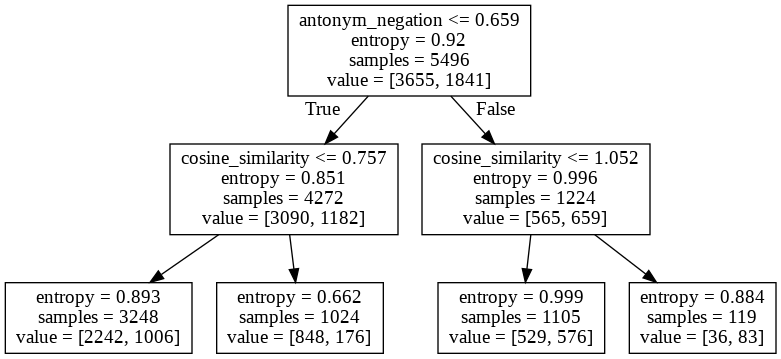

In [ ]:
#dtree = DecisionTreeClassifier() lr
#dtree = dtree.fit(X, y)
data = tree.export_graphviz(lr, out_file=None, feature_names=columns)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

Image(graph.create_png())

In [ ]:
#lt.savefig('mydecisiontree.png')

In [ ]:
importance = lr.feature_importances_

Feature: 0, Score: 0.75062
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.24938
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000


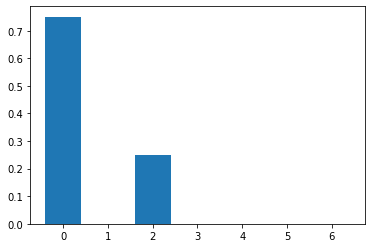

In [ ]:
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
#Decision Tree with Word2Vec Dataset
#After having performed 10-fold cross-val, best parameters are criterion:gini  , max_depth:5

In [ ]:
lr = DecisionTreeClassifier(criterion='gini',max_depth=5) 
model=lr.fit(x_train_w2v,y_train_w2v)
preds_w2v=model.predict(x_test_w2v)
#print(classification_report(y_test_w2v, preds_w2v))
#print(confusion_matrix(y_test_w2v, preds_w2v))

**Random Forest**

In [10]:
param_grid = {
    'max_depth': [1,2,3,8,10],
    'max_features': [2,3,4,5,6,7],
    'n_estimators': [300,400,500]
}

In [11]:
rf = RandomForestClassifier(random_state = 42)

In [12]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = 2, verbose = 2)

In [13]:
grid_search.fit(x_train, y_train)

NameError: ignored

In [16]:
model = RandomForestClassifier(max_depth= 8, max_features= 4, n_estimators= 500)   

In [ ]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds=model.predict(x_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1219
           2       0.20      0.00      0.00       639

    accuracy                           0.65      1858
   macro avg       0.43      0.50      0.40      1858
weighted avg       0.50      0.65      0.52      1858



In [ ]:
print(confusion_matrix(y_test, preds))

[[1215    4]
 [ 638    1]]


In [ ]:
# Pull out one tree from the forest
tree = model.estimators_[5]
tree = model.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

In [ ]:
# Get numerical feature importances
importances = list(model.feature_importances_)

Feature: 0, Score: 0.23809
Feature: 1, Score: 0.23292
Feature: 2, Score: 0.21678
Feature: 3, Score: 0.14467
Feature: 4, Score: 0.05419
Feature: 5, Score: 0.01186
Feature: 6, Score: 0.10148


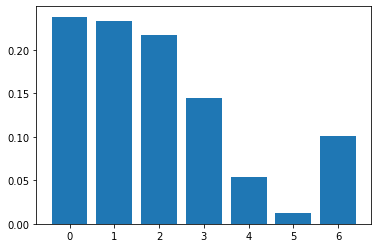

In [ ]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

In [ ]:
#Random Forest with Word2Vec Dataset
#After having performed 10-fold cross-val, best parameters are max_depth:8  , max_features:2 ,  n_estimators:300

In [25]:
model = RandomForestClassifier(max_depth= 1, max_features= 2, n_estimators= 300)   
model.fit(x_train_w2v, y_train_w2v)
preds_w2v=model.predict(x_test_w2v)

In [26]:
print(classification_report(y_test_w2v, preds_w2v))
#print(confusion_matrix(y_test_w2v, preds_w2v))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1219
           2       0.00      0.00      0.00       639

    accuracy                           0.66      1858
   macro avg       0.33      0.50      0.40      1858
weighted avg       0.43      0.66      0.52      1858



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ANN**

In [22]:
X= training_set.copy()

In [128]:
X['label'] = X['label'].replace([0, 1],0)
X['label'] = X['label'].replace(2,1)

In [ ]:
y=X["label"]

In [133]:
X.drop(['label'],axis=1,inplace=True)

In [135]:
X=standardized_dataset(X)
x_train,x_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=4)

In [136]:
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=7, activation='relu'))   
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [68]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=8, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X,y, cv=10)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 68.75% (1.83%)


In [38]:
model = Sequential()
model.add(Dense(7, input_dim=6, activation='relu'))  #60
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=0)    

In [148]:
_, accuracy = model.evaluate(x_train, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

172/172 [==============================] - 0s 1ms/step - loss: 0.6164 - accuracy: 0.6705
Training Accuracy: 67.05


In [149]:
# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

In [150]:
yhat_classes

array([0, 0, 0, ..., 0, 0, 0])

In [152]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.682678
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#Implementing NN with Word2vec dataset

In [28]:
x_train_w2v=np.asarray(x_train_w2v)

In [54]:
ip_dim = x_train_w2v.shape[1]
model = Sequential()
model.add(Dense(7, input_dim=ip_dim, activation='relu'))  #60
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
model.fit(x_train_w2v, np.asarray(y_train_w2v), epochs=100, batch_size=8, verbose=0)     

In [59]:
_, accuracy = model.evaluate(x_train_w2v, np.asarray(y_train_w2v))
print('Training Accuracy: %.2f' % (accuracy*100))

157/157 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.7984
Training Accuracy: 79.84


In [60]:
# predict probabilities for test set
yhat_probs = model.predict(np.asarray(x_test_w2v), verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

In [61]:
accuracy = accuracy_score(np.asarray(y_test_w2v), yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(np.asarray(y_test_w2v), yhat_classes, average="binary")
print('Precision: %f' % precision)
recall = recall_score(np.asarray(y_test_w2v), yhat_classes, average="binary")
print('Recall: %f' % recall)
f1 = f1_score(np.asarray(y_test_w2v), yhat_classes, average="binary")
print('F1 score: %f' % f1)

Accuracy: 0.656082
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Sparse Tensor**

In [25]:
b= training_set.copy()
b["label"]= b['label'].replace(0, "Entailment")
#b["label"]= b['label'].replace(1, "Neutral")
b["label"]= b['label'].replace(2, "Contradiction")

In [26]:
# Initialize the class
STC = SparseTensorClassifier(targets=["label"], features=b.loc[:, b.columns != 'label'])  

In [27]:
# Fit the training data
STC.fit(b[0:5000])

In [28]:
# Predict the test data
labels, probability, explainability = STC.predict(b[5000:])

In [ ]:
#labels

In [29]:
accuracy_score(b['label'][5000:], labels)

0.6149732620320856

In [73]:
print(classification_report(b['label'][5000:], labels))

               precision    recall  f1-score   support

Contradiction       0.34      0.99      0.51       644
   Entailment       0.44      0.01      0.01      1226

     accuracy                           0.34      1870
    macro avg       0.39      0.50      0.26      1870
 weighted avg       0.40      0.34      0.18      1870



In [31]:
test = b[5000:].reset_index()
labels, probability, explainability = STC.predict(test)

In [61]:
test.loc[17][['antonym_negation', 'label']]

antonym_negation                1
label               Contradiction
Name: 17, dtype: object

In [60]:
labels.loc[17]

label    Contradiction
Name: 17, dtype: object

In [62]:
probability.loc[17]

label
Contradiction    0.642485
Entailment       0.357515
Name: 17, dtype: float64

In [64]:
explainability.loc[(17,'Contradiction')][:]

features     score
item label                                                        
17   Contradiction                   antonym_negation: 1  0.009545
     Contradiction           jaccard: 0.5294117647058824  0.000895
     Contradiction                           polarity: 1  0.000015
     Contradiction  polarity_difference: -0.999999000001  0.000011
     Contradiction                      subject_sim: 0.0  0.000004

In [ ]:
#Sparse Tensor using words as input

In [65]:
b= data_train.copy()
b["label"]= b['label'].replace(0, "Entailment")
b["label"]= b['label'].replace(1, "Neutral")
b["label"]= b['label'].replace(2, "Contradiction")

In [66]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
items = []
for i, (_, row) in enumerate(b.iterrows()):
    item = {}
    item['premise'] = [row['premise'].split()]             
    item['hypothesis'] =  [row['hypothesis'].split()]    
    item['label'] = [row['label']]
    items.append(item)

items[0]

{'hypothesis': [['the',
   'rules',
   'developed',
   'in',
   'the',
   'interim',
   'were',
   'put',
   'together',
   'with',
   'these',
   'comments',
   'in',
   'mind']],
 'label': ['Entailment'],
 'premise': [['and',
   'these',
   'comments',
   'were',
   'considered',
   'in',
   'formulating',
   'the',
   'interim',
   'rules']]}

In [69]:
STC = SparseTensorClassifier(targets=['label'], features=['premise','hypothesis'])

In [70]:
STC.fit(items[0:70])

In [71]:
labels, probability, explain = STC.predict(items[5000:])

In [72]:
accuracy_score(b['label'][5000:], labels)

0.3433155080213904